In [2]:
# want to store this notebook in the notebooks folder, but want to keep non-relative imports
import os
os.chdir("..")

In [3]:
import sys
import time
import copy

from scipy.stats import norm
from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
import pickle
import os
from collections import defaultdict

/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
dfs = {}
for ex in ['genemania', 'pathway', 'regnet', 'genemania_lr', 'pathway_lr', 'regnet_lr',  'genemania_100', 'pathway_100', 'regnet_100', 'genemania_first', 'pathway_first', 'regnet_first', 'genemania_second', 'pathway_second', 'regnet_second']:
    dfs[ex] = pd.DataFrame(columns=['auc', 'gene_name', 'model', 'num_genes', 'seed', 'train_size'])
    for root, dirs, files in os.walk('experiments/results/old_gene_inference_results/' + ex):
        for f in files:
            if not f.startswith("slurm"):
                block = f.split('-')[-1].split('.')[0]
                graph = root.split('/')[-2]
                try:
                    dfs[ex] = dfs[ex].append(pd.DataFrame(pickle.load(open(os.path.join(root, f), 'rb'))['df']))
                except Exception:
                    import pdb; pdb.set_trace()
                    pass


In [4]:
agg_df = pd.DataFrame(columns=dfs['genemania'].columns)
for key, df in dfs.items():
    df['exp_id'] = key
    agg_df = pd.concat([agg_df, dfs[key]])


In [5]:
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [6]:
def create_graph(exp_id, df, std, slice_size, filter_isolates=False, title=''):

    if filter_isolates:
        graph = Graph()
        path = "data/graph/pancan-tissue-graph.hdf5"
        graph.load_graph(path)
        g = nx.from_numpy_matrix(graph.adj)
        mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
        g = nx.relabel_nodes(g, mapping)
        nodes_to_keep = set(g.nodes()).difference(nx.isolates(g))
        df = df[df['gene_name'].isin(nodes_to_keep)]

    
    grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
    small_neighborhood_mlp_df = df[df['num_genes'] == 50].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    big_neighborhood_mlp_df = df[df['num_genes'] == 16300].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    small_neighborhood_lr_df = df[df['num_genes'] == 50].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    big_neighborhood_lr_df = df[df['num_genes'] == 16300].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

    # remove the genes with high variance
    small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
    big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]


    # reset the index to the gene names (I don't like working with hierarchical indices)
    small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
    big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)


    # Find the genes which are low variance in the small neighborhood and large neighborhood dfs
    intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)


    big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
    small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
    mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)


    index_order = mlp_low_var_high_mean_df.index[0:slice_size]


    line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
    line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]

    l1 = line1['mean'] * 100
    l2 = line2['mean'] * 100
    fig, ax = plt.subplots()
    n1, bins1, patches1 = ax.hist(l1, 100, label="MLP - All Genes", density=0, alpha=0.75)
    n2, bins2, patches2 = ax.hist(l2, 100, label="MLP - 50 Neighbors", density=0, alpha=0.75)

    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("AUC Bucket")

    plt.legend()
    plt.show()


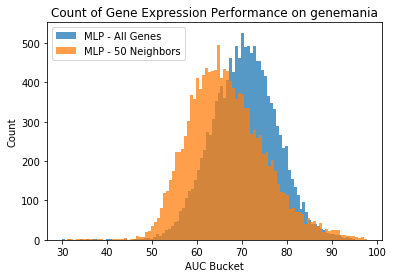

In [7]:
exp_id = 'genemania'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, title="Count of Gene Expression Performance on " + exp_id)


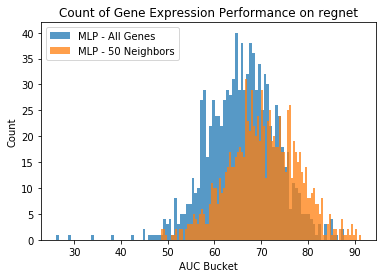

In [13]:
exp_id = 'regnet'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 1000
create_graph(exp_id, df, std, slice_size, title="Count of Gene Expression Performance on " + exp_id)


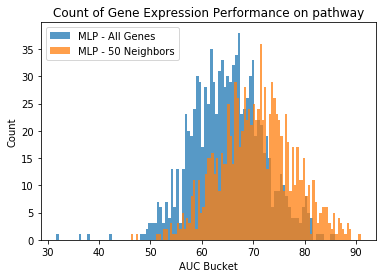

In [14]:
exp_id = 'pathway'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 1000
create_graph(exp_id, df, std, slice_size, title="Count of Gene Expression Performance on " + exp_id)


In [15]:
exp_id = 'genemania'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=True, title="Count of Gene Expression Performance on " + exp_id + " filtering isolates")

KeyError: "Unable to open object (object 'graph_data' doesn't exist)"

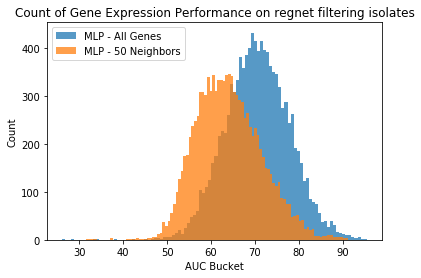

In [13]:
exp_id = 'regnet'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=True, title="Count of Gene Expression Performance on " + exp_id + " filtering isolates")

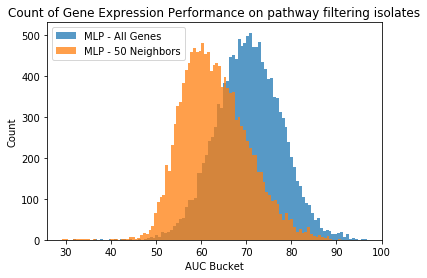

In [14]:
exp_id = 'pathway'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=True, title="Count of Gene Expression Performance on " + exp_id + " filtering isolates")


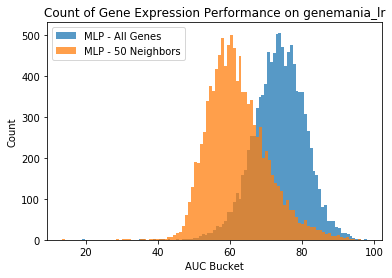

In [15]:
exp_id = 'genemania_lr'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


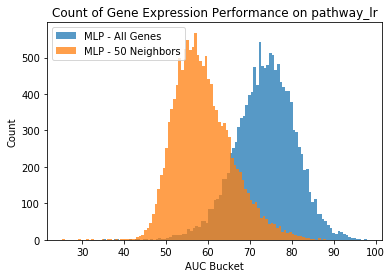

In [16]:
exp_id = 'pathway_lr'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


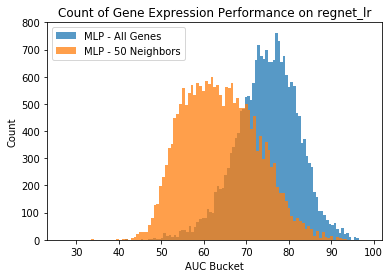

In [17]:
exp_id = 'regnet_lr'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


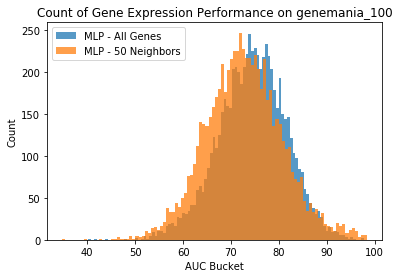

In [18]:
exp_id = 'genemania_100'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
df = df[df['model'] == 'MLP']
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


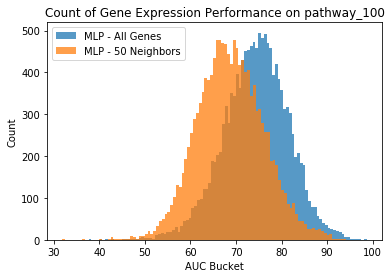

In [19]:
exp_id = 'pathway_100'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
df = df[df['model'] == 'MLP']
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


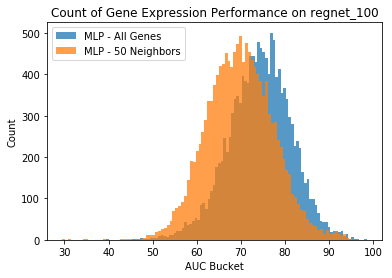

In [20]:
exp_id = 'regnet_100'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
df = df[df['model'] == 'MLP']
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


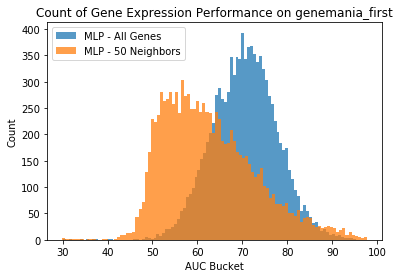

In [21]:
exp_id = 'genemania_first'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
df = df[df['model'] == 'MLP']
df2 = agg_df[agg_df['exp_id']=='genemania']
df2 = df2[df2['model'] == 'MLP']
df2 = df2[df2['num_genes']==16300]
df = pd.concat([df, df2])

std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


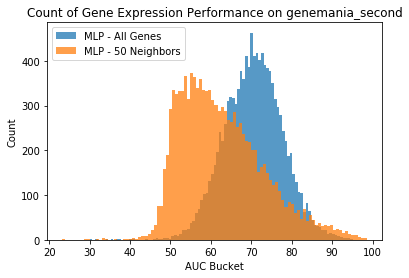

In [23]:
exp_id = 'genemania_second'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
df = df[df['model'] == 'MLP']
df2 = agg_df[agg_df['exp_id']=='genemania']
df2 = df2[df2['model'] == 'MLP']
df2 = df2[df2['num_genes']==16300]
df = pd.concat([df, df2])

std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)

In [13]:
#### Difference in performance

In [24]:

def create_graph_mean(exp_id, df, std, slice_size, filter_isolates=False, title=''):
    grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
    small_neighborhood_mlp_df = df[df['num_genes'] == 50].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    big_neighborhood_mlp_df = df[df['num_genes'] == 16300].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    small_neighborhood_lr_df = df[df['num_genes'] == 50].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    big_neighborhood_lr_df = df[df['num_genes'] == 16300].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])


    # remove the genes with high variance
    small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
    big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]


    # reset the index to the gene names (I don't like working with hierarchical indices)
    small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
    big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)


    # Find the genes which are low variance in the small neighborhood and large neighborhood dfs
    intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)


    big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
    small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
    mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

    index_order = mlp_low_var_high_mean_df.index[0:slice_size]


    line1 = mlp_low_var_high_mean_df.loc[index_order.tolist()]

    l1 = line1['mean'] * 100
    fig, ax = plt.subplots()
    n1, bins1, patches1 = ax.hist(l1, 100, label="MLP Improvement with 50 Neighbors", density=0, alpha=0.75)

    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("AUC Improvement")

    plt.legend()
    plt.show()



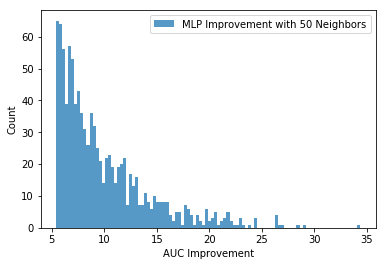

In [25]:
exp_id = 'genemania'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
#df = df[df['model'] == 'MLP']
std = 1.0
slice_size = 1000


create_graph_mean(exp_id, df, std, slice_size, filter_isolates=False, title='')

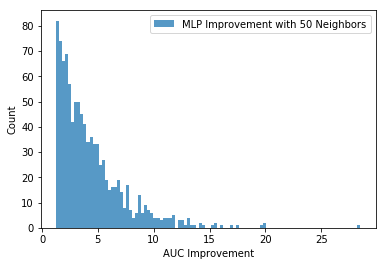

In [26]:
exp_id = 'regnet'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
#df = df[df['model'] == 'MLP']
std = 1.0
slice_size = 1000


create_graph_mean(exp_id, df, std, slice_size, filter_isolates=False, title='')

In [27]:
agg_df['exp_id'].unique()

array(['regnet_first', 'genemania_second', 'regnet_lr', 'genemania_lr',
       'pathway_first', 'genemania', 'regnet_100', 'pathway_100',
       'regnet', 'genemania_first', 'pathway', 'genemania_100',
       'pathway_lr'], dtype=object)

In [30]:
def create_line(df1, df2):
    small_neighborhood_mlp_df = df1[df1['num_genes'] == 50].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    big_neighborhood_mlp_df = df2[df2['num_genes'] == 16300].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    mlp_low_var_high_mean_df = small_neighborhood_mlp_df.sub(big_neighborhood_mlp_df).sort_values('mean', ascending=False)
    return mlp_low_var_high_mean_df

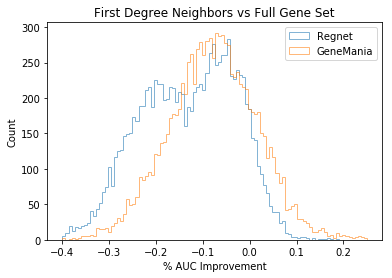

In [36]:
std = 1.0
slice_size = 100000


df1 = agg_df[agg_df['exp_id']=='regnet_first'].dropna()
df11 = agg_df[agg_df['exp_id']=='regnet'].dropna()
df2 = agg_df[agg_df['exp_id']=='genemania_first'].dropna()
df22 = agg_df[agg_df['exp_id']=='genemania'].dropna()
df3 = agg_df[agg_df['exp_id']=='pathway_first'].dropna()
df33 = agg_df[agg_df['exp_id']=='pathway'].dropna()

line1 = create_line(df1, df11)
line2 = create_line(df2, df22)
line3 = create_line(df3, df33)

l1 = line1['mean']
l2 = line2['mean']
l3 = line3['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')
# n1, bins1, patches1 = ax.hist(l3, range=(-.4, .25), bins=100, label="Pathway Commons", density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()



In [32]:
print len(l1[l1>=0.])
print len(l1)
print len(l1[l1>0.])/float(len(l1))


print len(l2[l2>0.])
print len(l2)
print len(l2[l2>0.])/float(len(l2))


print len(l3[l3>0.])
print len(l3)
print len(l3[l3>0.])/float(len(l3))



931
14879
0.0625714093689
1996
14879
0.134148800323
42
14879
0.00282277034747


In [33]:
small_neighborhood_mlp_df = df1[df1['num_genes'] == 50].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df1[df1['num_genes'] == 16300].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_mlp_df.sub(big_neighborhood_mlp_df)


,,,mean,std
gene_name,model,train_size,,
A1BG,MLP,50,NaN,NaN
A1CF,MLP,50,NaN,NaN
A2M,MLP,50,NaN,NaN
A2ML1,MLP,50,NaN,NaN
A4GALT,MLP,50,NaN,NaN
A4GNT,MLP,50,NaN,NaN
AAAS,MLP,50,NaN,NaN
AACS,MLP,50,NaN,NaN
AAGAB,MLP,50,NaN,NaN


In [34]:
print df1[:10]
print df2[:10]

        auc        exp_id gene_name model num_genes seed train_size
0  0.677408  regnet_first      AAAS   MLP        50    0         50
1  0.729813  regnet_first      AAAS   MLP        50    1         50
2  0.665848  regnet_first      AAAS   MLP        50    2         50
3  0.596413  regnet_first     AAGAB   MLP        50    0         50
4  0.631581  regnet_first     AAGAB   MLP        50    1         50
5  0.599762  regnet_first     AAGAB   MLP        50    2         50
6  0.810825  regnet_first      ABAT   MLP        50    0         50
7  0.735502  regnet_first      ABAT   MLP        50    1         50
8  0.749584  regnet_first      ABAT   MLP        50    2         50
9  0.602010  regnet_first     ABCD4   MLP        50    0         50
        auc           exp_id gene_name model num_genes seed train_size
0  0.668749  genemania_first      AAAS   MLP        50    0         50
1  0.672332  genemania_first      AAAS   MLP        50    1         50
2  0.532871  genemania_first      AAAS 

In [35]:
agg_df['exp_id'].unique()

array(['regnet_first', 'genemania_second', 'regnet_lr', 'genemania_lr',
       'pathway_first', 'genemania', 'regnet_100', 'pathway_100',
       'regnet', 'genemania_first', 'pathway', 'genemania_100',
       'pathway_lr'], dtype=object)